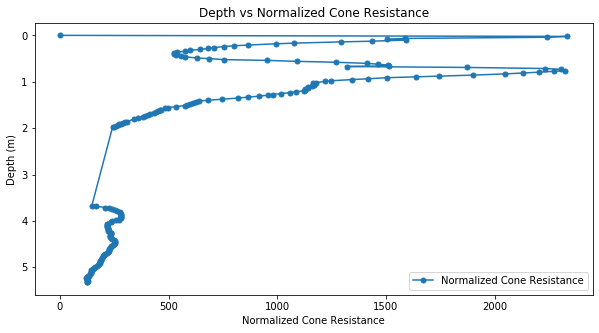

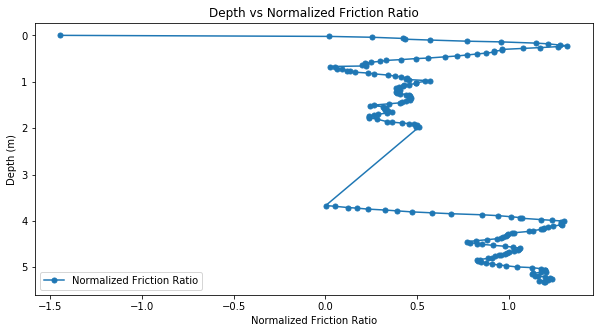

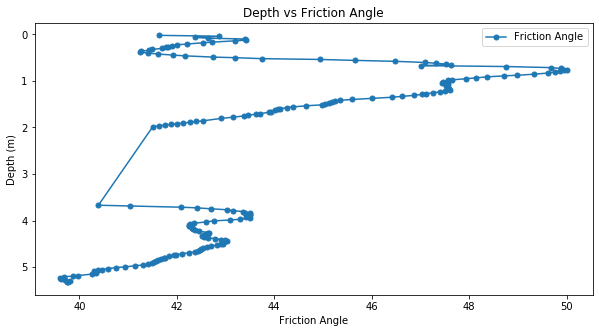

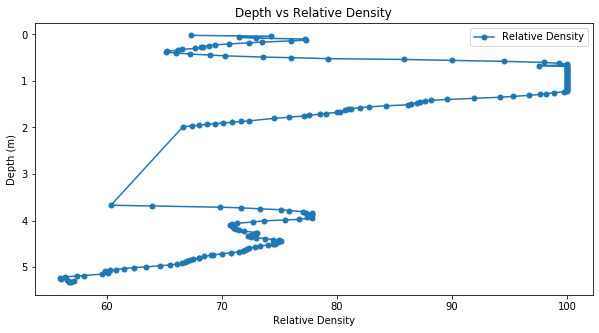

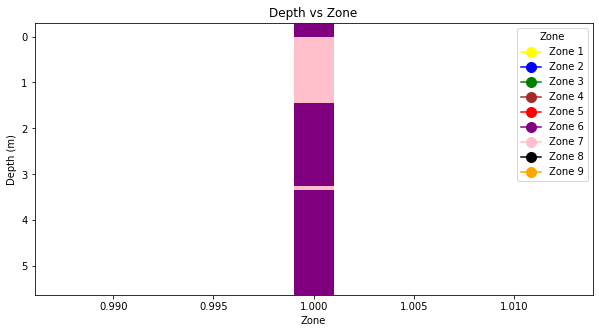

changes made, saving...
changes saved


In [46]:
import openpyxl
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np

workbook = openpyxl.load_workbook("CSC593 Term Project.xlsx")
sheet = workbook.active

#Insert New Column with Tip Resistance Converted to kPa from MPa
mpa_to_kpa_conversion = 1000
sheet.insert_cols(2)
new_column_header = "Tip Resistance (kPa)"
sheet.cell(row=2, column=2, value=new_column_header)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=1, max_col=1):
    for tip_resistance_cell in row:
        tip_resistance_mpa = tip_resistance_cell.value
        if tip_resistance_mpa is not None:
            tip_resistance_kpa = tip_resistance_mpa * mpa_to_kpa_conversion
            sheet.cell(row=tip_resistance_cell.row, column=2, value=tip_resistance_kpa)

# Insert New Column with Sleeve Friction Converted to kPa from MPa
mpa_to_kpa_conversion = 1000
sheet.insert_cols(4)
new_column_header_sleeve_friction = "Sleeve Friction (kPa)"
sheet.cell(row=2, column=4, value=new_column_header_sleeve_friction)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=3, max_col=3):
    for sleeve_friction_cell in row:
        sleeve_friction_mpa = sleeve_friction_cell.value
        if sleeve_friction_mpa is not None:
            sleeve_friction_kpa = sleeve_friction_mpa * mpa_to_kpa_conversion
            sheet.cell(row=sleeve_friction_cell.row, column=4, value=sleeve_friction_kpa)
            
            
#Calculate Total Stress from Unit Weight and Depth
unit_weight = 19
new_column_header_TotalStress = "Total Stress"
sheet.cell(row=2, column=7, value=new_column_header_TotalStress)
for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=6, max_col=6):
    for depth_cell in row:
        depth=depth_cell.value
        if depth is not None:
            total_stress = depth * unit_weight
            
            sheet.cell(row=depth_cell.row, column=7, value=total_stress)

#Calculate Effective Stress from Total Stress and Depth            
unit_weight_water = 9.81
new_column_header_EffectiveStress = "Effective Stress"
sheet.cell(row=2, column = 8, value= new_column_header_EffectiveStress)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=6, max_col=7):
    for total_stress_cell in row:
        total_stress= total_stress_cell.value
        depth = sheet.cell(row=total_stress_cell.row, column =6).value
        
        if depth is not None and total_stress is not None:
            if depth > 3.35:
                effective_stress= total_stress - (unit_weight_water * (depth- 3.35))
            else:
                effective_stress=total_stress
           
           
            sheet.cell(row=total_stress_cell.row, column = 8, value = effective_stress)

# Calculate Normalized Cone Resistance
new_column_header_normalized_cone_resistance = "Normalized Cone Resistance"
sheet.cell(row=2, column= 9, value=new_column_header_normalized_cone_resistance)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=2, max_col=sheet.max_column):
    for cell in row:
        if cell.column == 2:
            tip_resistance_kpa = cell.value
        elif cell.column == 7:
            total_stress = cell.value
        elif cell.column == 8:
            effective_stress = cell.value

        if effective_stress != 0:  
            normalized_cone_resistance = (tip_resistance_kpa - total_stress) / effective_stress
        else:
            normalized_cone_resistance = 0
        
        sheet.cell(row=row[0].row, column=sheet.max_column, value=normalized_cone_resistance)            


# Calculate Normalized Friction Ratio
new_column_header_normalized_friction_ratio = "Normalized Friction Ratio"
sheet.cell(row=2, column=10, value=new_column_header_normalized_friction_ratio)        

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=2, max_col=sheet.max_column):
    for cell in row:
        if cell.column == 4:
            sleeve_friction_kpa = cell.value
        elif cell.column == 2:
            tip_resistance_kpa = cell.value
        elif cell.column == 7:
            total_stress = cell.value

    if (tip_resistance_kpa - total_stress) != 0:
        normalized_friction_ratio = (sleeve_friction_kpa / (tip_resistance_kpa - total_stress)) * 100
    else:
        normalized_friction_ratio = 0

    sheet.cell(row=row[0].row, column=sheet.max_column, value=normalized_friction_ratio)

# Calculate Soil Behavior Type index (Ic)
new_column_header_ic = "Soil Behavior Type Index (Ic)"
sheet.cell(row=2, column=11, value=new_column_header_ic)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=9, max_col=10):
    for cell in row:
        normalized_cone_resistance = sheet.cell(row=cell.row, column=cell.column - 1).value
        normalized_friction_ratio = sheet.cell(row=cell.row, column=cell.column).value

        if (
            normalized_cone_resistance is not None
            and normalized_friction_ratio is not None
            and normalized_cone_resistance > 0  # Ensure a positive value for logarithm
            and normalized_friction_ratio > 0    # Ensure a positive value for logarithm
        ):
            ic = math.sqrt((3.47 - math.log10(normalized_cone_resistance))**2 + (math.log10(normalized_friction_ratio) + 1.22)**2)
            sheet.cell(row=cell.row, column=11, value=ic)
        else:
            sheet.cell(row=cell.row, column=11, value=None)

# Create a new column for Soil Behavior Type based on Ic values
new_column_header_soil_behavior_zone = "Soil Behavior Type (Zone)"
sheet.cell(row=2, column=12, value=new_column_header_soil_behavior_zone)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=11, max_col=11):
    ic_cell = row[0]

    if ic_cell.value is not None:
        ic_value = ic_cell.value

        if ic_value > 3.6:
            soil_behavior_zone = "Zone 2"
        elif 2.95 <= ic_value <= 3.6:
            soil_behavior_zone = "Zone 3"
        elif 2.6 <= ic_value < 2.95:
            soil_behavior_zone = "Zone 4"
        elif 2.05 <= ic_value < 2.6:
            soil_behavior_zone = "Zone 5"
        elif 1.31 <= ic_value < 2.05:
            soil_behavior_zone = "Zone 6"
        else:
            soil_behavior_zone = "Zone 7"

        sheet.cell(row=ic_cell.row, column=12, value=soil_behavior_zone)
    else:
        sheet.cell(row=ic_cell.row, column=12, value=None)
    
# Create a new column for Soil Behavior Type based on Zone
new_column_header_soil_behavior = "Soil Behavior Type"
sheet.cell(row=2, column=13, value=new_column_header_soil_behavior)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=12, max_col=12):
    zone_cell = row[0]

    if zone_cell.value is not None:
        zone_value = zone_cell.value

        if zone_value == "Zone 1":
            soil_behavior = "Sensitive, fine grained"
        elif zone_value == "Zone 2":
            soil_behavior = "Organic Soils - Clays"
        elif zone_value == "Zone 3":
            soil_behavior = "Clays - Silty Clay to Clay"
        elif zone_value == "Zone 4":
            soil_behavior = "Silt Mixtures - Clayey silt to silty clay"
        elif zone_value == "Zone 5":
            soil_behavior = "Sand Mixtures - Silty sand to sandy silt"
        elif zone_value == "Zone 6":
            soil_behavior = "Sands - Clean sand to silty sand"
        elif zone_value == "Zone 7":
            soil_behavior = "Gravelly sand to dense sand"
        elif zone_value == "Zone 8":
            soil_behavior = "Very stiff sand to clayey sand"
        elif zone_value == "Zone 9":
            soil_behavior = "Very stiff, fine grained"
        else:
            soil_behavior = None

        sheet.cell(row=zone_cell.row, column=13, value=soil_behavior)
    else:
        sheet.cell(row=zone_cell.row, column=13, value=None)

# Calculate Friction Angle
new_column_header_friction_angle = "Friction Angle"
sheet.cell(row=2, column=14, value=new_column_header_friction_angle)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=2, max_col=7):
    for cell in row:
        tip_resistance_kpa = sheet.cell(row=cell.row, column=2).value
        effective_stress = sheet.cell(row=cell.row, column=7).value

        if tip_resistance_kpa is not None and effective_stress is not None and effective_stress > 0:
            friction_angle = 17.6 + 11 * math.log10((tip_resistance_kpa / 100) / math.sqrt(effective_stress / 100))
            sheet.cell(row=cell.row, column=14, value=friction_angle)

# Calculate Relative Density (Dr)
new_column_header_relative_density = "Relative Density (Dr)"
sheet.cell(row=2, column=15, value=new_column_header_relative_density)

for row in sheet.iter_rows(min_row=3, max_row=sheet.max_row, min_col=2, max_col=7):
    for cell in row:
        tip_resistance_kpa = sheet.cell(row=cell.row, column=2).value
        effective_stress = sheet.cell(row=cell.row, column=7).value

        if tip_resistance_kpa is not None and effective_stress is not None and effective_stress > 0:
            relative_density = 100 * (0.268 * math.log((tip_resistance_kpa / 100) / math.sqrt(effective_stress / 100)) - 0.675)

            # Ensure Dr does not exceed 100
            sheet.cell(row=cell.row, column=15, value=min(relative_density, 100))

# Making Plots of Data
depth_data = [sheet.cell(row=row, column=6).value for row in range(3, sheet.max_row + 1)]
normalized_cone_resistance_data = [sheet.cell(row=row, column=9).value for row in range(3, sheet.max_row + 1)]
normalized_friction_ratio_data = [sheet.cell(row=row, column=10).value for row in range(3, sheet.max_row + 1)]
friction_angle_data = [sheet.cell(row=row, column=14).value for row in range(3, sheet.max_row + 1)]
relative_density_data = [sheet.cell(row=row, column=15).value for row in range(3, sheet.max_row + 1)]

# Replace missing data with NaN
depth_data = [np.nan if depth is None else depth for depth in depth_data]
normalized_cone_resistance_data = [np.nan if val is None else val for val in normalized_cone_resistance_data]
normalized_friction_ratio_data = [np.nan if val is None else val for val in normalized_friction_ratio_data]
friction_angle_data = [np.nan if val is None else val for val in friction_angle_data]
relative_density_data = [np.nan if val is None else val for val in relative_density_data]

# Plotting depth vs normalized_cone_resistance
plt.figure(figsize=(10, 5))
plt.plot(normalized_cone_resistance_data, depth_data, label='Normalized Cone Resistance', marker='o', linestyle='-', markersize=5)
plt.xlabel('Normalized Cone Resistance')
plt.ylabel('Depth (m)')
plt.title('Depth vs Normalized Cone Resistance')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.savefig('Depth_vs_Normalized_Cone_Resistance.jpg')
plt.show()

# Plotting depth vs normalized_friction_ratio
plt.figure(figsize=(10, 5))
plt.plot(normalized_friction_ratio_data, depth_data, label='Normalized Friction Ratio', marker='o', linestyle='-', markersize=5)
plt.xlabel('Normalized Friction Ratio')
plt.ylabel('Depth (m)')
plt.title('Depth vs Normalized Friction Ratio')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.savefig('Depth_vs_Normalized_Friction_Ratio.jpg')
plt.show()

# Plotting depth vs friction_angle
plt.figure(figsize=(10, 5))
plt.plot(friction_angle_data, depth_data, label='Friction Angle', marker='o', linestyle='-', markersize=5)
plt.xlabel('Friction Angle')
plt.ylabel('Depth (m)')
plt.title('Depth vs Friction Angle')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.savefig('Depth_vs_Friction_Angle.jpg')
plt.show()

# Plotting depth vs relative_density
plt.figure(figsize=(10, 5))
plt.plot(relative_density_data, depth_data, label='Relative Density', marker='o', linestyle='-', markersize=5)
plt.xlabel('Relative Density')
plt.ylabel('Depth (m)')
plt.title('Depth vs Relative Density')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.legend()
plt.savefig('Depth_vs_Relative_Density.jpg')
plt.show()
 

# Extract data from the sheet
depth_data = [sheet.cell(row=row, column=6).value for row in range(3, sheet.max_row + 1)]
zone_data = [sheet.cell(row=row, column=12).value for row in range(3, sheet.max_row + 1)]

# Define colors for each zone
zone_colors = {
    "Zone 1": 'yellow',
    "Zone 2": 'blue',
    "Zone 3": 'green',
    "Zone 4": 'brown',
    "Zone 5": 'red',
    "Zone 6": 'purple',
    "Zone 7": 'pink',
    "Zone 8": 'black',
    "Zone 9": 'orange'
}


# Assign colors to zones
zone_colors_list = [zone_colors.get(zone, 'white') for zone in zone_data]

# Create a scatter plot
plt.figure(figsize=(10, 5))
scatter = plt.scatter([1] * len(depth_data), depth_data, c=zone_colors_list, edgecolors='k', s=200, marker='s')

# Connect the zones with lines
for i in range(len(depth_data) - 1):
    if zone_data[i] in zone_colors and zone_data[i + 1] in zone_colors:
        plt.plot([1, 1], [depth_data[i], depth_data[i + 1]], color=zone_colors[zone_data[i]], linestyle='-', linewidth=40)

# Set labels and title
plt.ylabel('Depth (m)')
plt.xlabel('Zone')
plt.title('Depth vs Zone')

# Invert the y-axis
plt.gca().invert_yaxis()

# Create a legend
legend_labels = list(zone_colors.keys())
legend_handles = [plt.Line2D([0], [0], marker='o', color=zone_colors[zone], markersize=10) for zone in legend_labels]
plt.legend(legend_handles, legend_labels, title='Zone', loc='upper right')

# Display the plot
plt.savefig('Depth_vs_Zone_Type.jpg')
plt.show()

print ("changes made, saving...")           
workbook.save("CSC593 Term Project.xlsx")
print("changes saved")

